In [1]:
##### # Imports

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from random import randint
from fastai.vision import *

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

import treeinterpreter as ti

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import sklearn.utils.validation

##import model
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn import metrics

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## DL imports
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## Pytorch has this 
#export
from torch import optim


#Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features_sc.csv')
test_features = pd.read_csv('data/testing_features_sc.csv')
train_labels = pd.read_csv('data/training_labels_proc.csv', names= ['score'])
test_labels = pd.read_csv('data/testing_labels_proc.csv' , names= ['score'])

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (69496, 48)
Testing Feature Size:   (29784, 48)
Training Labels Size:   (69496, 1)
Testing Labels Size:    (29784, 1)


In [3]:
train_features.head()

,CurrentLoanAmount,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,log_Current Credit Balance,sqrt_Maximum Open Credit,log_Maximum Open Credit,LoanStatus_Charged Off,LoanStatus_Fully Paid,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,0.001171,0.029752,0.035463,0.184132,0.144737,0.000000,0.002425,0.000119,0.000000,0.0,0.652074,0.010907,0.572832,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006533,0.057573,0.047340,0.294910,0.131579,0.000000,0.012913,0.000664,0.000000,0.0,0.748705,0.025764,0.654096,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.022957,0.018410,0.333832,0.065789,0.083333,0.002418,0.000186,0.166667,0.0,0.651909,0.013647,0.594021,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.002043,0.021447,0.027175,0.121257,0.105263,0.000000,0.001723,0.000252,0.000000,0.0,0.632322,0.015876,0.608321,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.031225,0.056914,0.133234,0.118421,0.083333,0.004172,0.000140,0.166667,0.0,0.683430,0.011848,0.580652,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Scale both Training and test set


# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(train_labels)

# Transform both the training and testing data
train_labels = scaler.transform(train_labels)
#test_labels = scaler.transform(test_features)

In [5]:
train_labels
# mask = train_labels['score'] >= 710
# mask_low = train_labels['score'] < 710

array([[0.861446],
       [0.957831],
       [0.86747 ],
       [0.831325],
       ...,
       [0.855422],
       [0.746988],
       [0.903614],
       [0.921687]])

In [6]:
# train_labels.loc[mask, 'score'] = 1
# train_labels.loc[mask_low, 'score'] = 0

In [7]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [8]:
train_X , valid_X = split_vals(train_features, 40000)
train_y , valid_y = split_vals(train_labels, 40000)
valid_y = np.ravel(valid_y)
train_y = np.ravel(train_y)
valid_y.shape


(29496,)

In [9]:
## Default model
m = RandomForestRegressor(max_features='auto', criterion='mse', max_depth=5,max_leaf_nodes=None, 
                          min_samples_split=4, min_samples_leaf=4, n_estimators=50,n_jobs=-1, 
                          min_weight_fraction_leaf=0.0, oob_score=True)

%time m.fit(train_X, train_y)

Wall time: 3.95 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [10]:
def mse(x,y): 
    x = scaler.inverse_transform(x.reshape(-1,1))
    y = scaler.inverse_transform(y.reshape(-1,1))
    return np.abs(y-x).mean()

def print_score(m):
    res = [mse(m.predict(train_X), train_y), mse(m.predict(valid_X), valid_y),
                m.score(train_X, train_y), m.score(valid_X, valid_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [11]:
mse(m.predict(valid_X), valid_y)

15.462840490598774

## Class to Instantiate Random Forest model and extract DT preds

In [12]:
class RFmodel():
    def __init__(self, trees, criterion, x_train, y_train, x_valid, y_valid, depth=15, model=None):
            if(model != None):
                self.fit = False
                self.m = model
                self.x_train = x_train
                self.y_train = y_train
                self.x_valid = x_valid
                self.y_valid = y_valid
                
            else:
                self.fit = True
                self.m = RandomForestRegressor(max_features='auto', criterion=criterion, max_depth=depth,max_leaf_nodes=None, 
                          min_samples_split=4, min_samples_leaf=4, n_estimators=trees,n_jobs=-1, 
                          min_weight_fraction_leaf=0.0)
                
                self.x_train = x_train
                self.y_train = y_train
                self.x_valid = x_valid
                self.y_valid = y_valid
            print(self.m)
            
    def fit_model(self, dt = False):
        
        if(self.fit):
            print('Fitting model...')
            %time self.m = self.m.fit(self.x_train, self.y_train)

        if(dt):
            m = self.m
            print("Getting values from desicion trees...")
            dt_train = []
            dt_valid = []
            for dt in m.estimators_:
                dt_train.append(dt.predict(self.x_train))
                dt_valid.append(dt.predict(self.x_valid))
                                
            dt_train = torch.Tensor(dt_train)
            dt_valid = torch.Tensor(dt_valid)
            
            self.train_ds, self.valid_ds = self.getDataset(dt_train, dt_valid)
            return self.train_ds, self.valid_ds
            
    def getRfLoss(self):
        valid_pred = self.m.predict(self.x_valid)
        train_pred = self.m.predict(self.x_train)
        
        valid_loss = mse(valid_pred, self.y_valid)
        train_loss = mse(train_pred, self.y_train)
        
        return train_loss, valid_loss
    
    def getDataset(self, dt_train, dt_valid):
        print(dt_train.shape)
        print(dt_valid.shape)
         
        yb_train = np.array(self.y_train)
        yb_train = torch.Tensor(yb_train)
        
        yb_valid = np.array(valid_y)
        yb_valid = torch.Tensor(yb_valid)
        print(yb_valid.shape)
        print(yb_train.shape)

        xb_train = torch.Tensor(dt_train)
        xb_train = xb_train.t()
        
        xb_valid = torch.Tensor(dt_valid)
        xb_valid = xb_valid.t()
        print(xb_train.shape)
        print(xb_valid.shape)
        
        train_ds = TensorDataset(xb_train, yb_train)
        valid_ds = TensorDataset(xb_valid, yb_valid)
        
        return train_ds, valid_ds

In [13]:
rf = RFmodel(300, 'mae', train_X, train_y, valid_X, valid_y,model=m)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)


In [14]:
train_ds, valid_ds = rf.fit_model(True)
len(train_ds[0])

Getting values from desicion trees...
torch.Size([50, 40000])
torch.Size([50, 29496])
torch.Size([29496])
torch.Size([40000])
torch.Size([40000, 50])
torch.Size([29496, 50])


2

In [15]:
rf.m.n_estimators

50

In [16]:
t, v = rf.getRfLoss()
print(t, v)

15.500397740179967 15.462840490598772


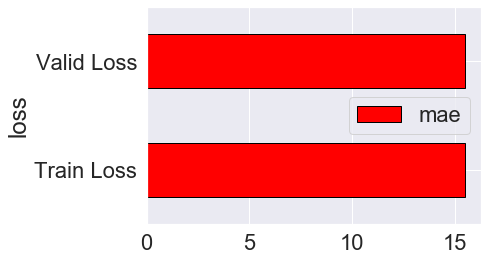

In [17]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'loss': ['Train Loss',
                                           'Valid Loss'],
                                 'mae': [t, v]})
model_comparison.plot(x = 'loss', y = 'mae', kind = 'barh', color = 'red', edgecolor = 'black')


## Object to store neural network results

In [18]:
class Recorder():
    def __init__(self):
        self.valid_losses, self.losses, self.lr, self.mse, self.mse_valid =[], [], [], [], []
        
    def accumulate(self,loss, mse, lr):
        self.losses.append(loss)
        self.mse.append(mse)
        self.lr.append(lr)
    
    def accumulate_v(self, loss, mse):
        self.valid_losses.append(loss)
        self.mse_valid.append(mse)
        
    def plot_loss(self):
        plt.plot(self.losses)
        return self.losses
    
    def plot_validloss(self):
        plt.plot(self.valid_losses)
        return self.valid_losses
    
    def plot_lr(self):
        plt.plot(self.lr)
        return self.lr
    
    def plot_mse(self):
        plt.plot(self.mse)
        plt.plot(self.mse_valid)
        return self.mse, self.mse_valid

### Methods to NN generate model and init weights using kaiming normal initialization

In [41]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


def getDNNmodel(n, lr = 1e-03):
    n = n
    nh = 500
    nh2 = 128
    nh3 = 64
    c = 1
    model = nn.Sequential(nn.Linear(n,nh), 
                          nn.ReLU(), 
                          nn.Linear(nh,nh2), 
                          nn.ReLU(), 
                          nn.Linear(nh2, nh3),
                          nn.ReLU(),
                          nn.Linear(nh3,1))
    #init_weights(model)

    
    return model, optim.Adam(model.parameters(), lr=lr)

In [66]:
def accuracy(out, yb): return (abs(out-yb)).float().mean()
loss_func =nn.MSELoss()

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 3 epochs"""
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if(epoch %7 == 0):
            param_group['lr'] = lr / 2
            lr = lr / 2
    return lr

## Object to run RFDNN model.

In [68]:
class RfDNN():
    def __init__(self, train_ds, valid_ds, error_metrics, trees, model=None, bs = 3000): 

        self.model = model
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.bs = bs
        self.n = len(train_ds)
        self.nv = len(valid_ds)
        self.error_metrics = error_metrics
        self.record = Recorder()
        self.trees = trees
    
    @property
    def recorder(self):
        return self.record

    def runDNN(self, epoch):
        self.epoch = epoch
        
        if(self.model == None):
            self.model, self.opt = getDNNmodel(self.trees, lr= 1e-02)
            
        print(self.model)
        ## Refactored mini batch training
        bs = self.bs
        tot_loss,tot_acc, tot_mse = 0.,0.,0.
        for epoc in range(epoch):
            lr = adjust_learning_rate(self.opt, epoc)
            print('Learning rate: ', lr)
            for i in range((self.n-1)//bs + 1):
                
                self.xb, self.yb = train_ds[i*bs:i*bs+bs]
                xb, yb = self.xb, self.yb.unsqueeze(-1)
                pred = self.model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
                print('#', end="")
                acc_loss = accuracy(pred, yb)
                mse = self.error_metrics(pred, yb)
                self.record.accumulate([loss.detach().cpu() ,acc_loss], mse, lr)
            
            print()
            print('For epoch', epoc, ' loss:', loss.detach().cpu().numpy(), 'acc:',acc_loss.detach().numpy(),'mse:', mse)
            
            with torch.no_grad():
                
                for i in range((self.nv-1)//bs + 1):
                    xb, yb = valid_ds[i*bs:i*bs+bs]
                    yb = yb.unsqueeze(-1)
                    pred_v = self.model(xb)
                    loss_v = loss_func(pred_v, yb)
                    acc_v = accuracy(pred_v, yb)
                    mse_v = self.error_metrics(pred_v, yb)
                    self.record.accumulate_v([loss_v.detach().cpu().numpy() ,acc_v], mse)
                print('Valid_loss:', loss_v.detach().cpu().numpy(),'valid_acc:',acc_v.numpy(), ' mse:', mse_v)
                print()
                
        
    def getValidError(self, rows):
        self.xv, self.yv = valid_ds[:rows]
        pred = self.model(self.xv)
        print('Valid accuracy: ', self.error_metrics(pred.squeeze(-1), self.yv))
        
        return pred, self.error_metrics(pred.squeeze(-1), self.yv)

In [72]:
rfDNN = RfDNN(train_ds, valid_ds, mse,trees = rf.m.n_estimators, bs=5000)

In [73]:
rfDNN.runDNN(20)

Sequential(
  (0): Linear(in_features=100, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Learning rate:  0.005
########
For epoch 0  loss: 0.17402159 acc: 0.39722246 mse: 65.9389238055952
Valid_loss: 0.1127121 valid_acc: 0.3147296  mse: 52.24511686098195

Learning rate:  0.005
########
For epoch 1  loss: 0.020934263 acc: 0.10514946 mse: 17.454809952998907
Valid_loss: 0.022997467 valid_acc: 0.122226685  mse: 20.28963095114941

Learning rate:  0.005
########
For epoch 2  loss: 0.025733499 acc: 0.11441422 mse: 18.992759611273556
Valid_loss: 0.029196026 valid_acc: 0.12162854  mse: 20.190338321197512

Learning rate:  0.005
########
For epoch 3  loss: 0.021451976 acc: 0.11387672 mse: 18.903538994479923
Valid_loss: 0.019648062 valid_acc: 0.105357416  mse: 17.489332093603682

Learning rate:  0.

In [74]:
preds, _ = rfDNN.getValidError(25000)
preds = np.ravel(preds.detach().cpu().numpy())



Valid accuracy:  16.98611210246131


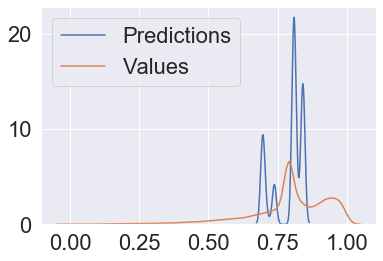

In [75]:
sns.kdeplot(preds, label = 'Predictions')
sns.kdeplot(valid_y[:20000], label = 'Values')

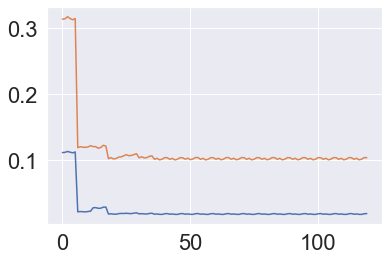

In [76]:
lss = rfDNN.recorder.plot_validloss()

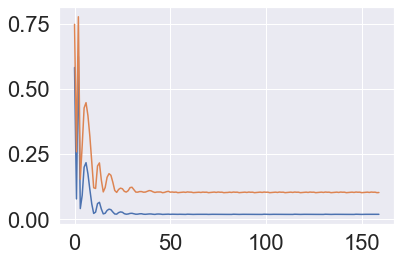

In [77]:
_ = rfDNN.recorder.plot_loss()

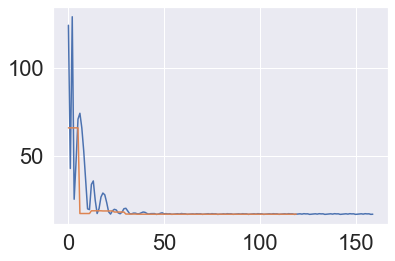

In [78]:
_, _= rfDNN.recorder.plot_mse()

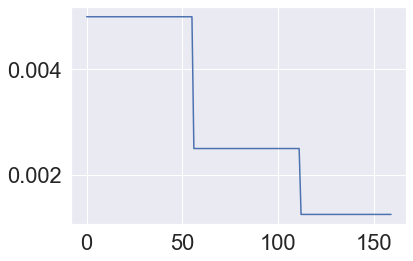

In [80]:
_= rfDNN.recorder.plot_lr()

### Run the model on different number of trees

In [81]:
# Dataframe to hold the results
rfdnn_chart = pd.DataFrame(columns = ['Trees',
                                      'RFtrainLoss',
                                      'RFvalidLoss'])
dicto = {
    "Trees": 500,
    "RFtrainLoss": t,
    "RFvalidLoss": v
}

valid_acc, DNN_loss, DNN_valid, DNN_mse =[], [], [], []

rfdnn_chart



,Trees,RFtrainLoss,RFvalidLoss


## Rfdnn training

Fitting RF with trees  2
Wall time: 7.51 s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
RF train: 17.347270732244922  RF valid: 17.20560464129756
Getting values from desicion trees...
torch.Size([150, 40000])
torch.Size([150, 29496])
torch.Size([29496])
torch.Size([40000])
torch.Size([40000, 150])
torch.Size([29496, 150])
Running DNN for trees:  2 Learning rate: 1e-03
Sequential(
  (0): Linear(in_features=150, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=Tr

For epoch 14  loss: 0.017199788 acc: 0.09328198 mse: 15.484809018398076
Valid_loss: 0.017360354 valid_acc: 0.094006576  mse: 15.60509404906791

Learning rate:  0.00125
########
For epoch 15  loss: 0.017200865 acc: 0.09326275 mse: 15.481616937971861
Valid_loss: 0.017359111 valid_acc: 0.09402917  mse: 15.60884018866279

Learning rate:  0.00125
########
For epoch 16  loss: 0.01719642 acc: 0.09332618 mse: 15.492145540166646
Valid_loss: 0.017357256 valid_acc: 0.09410124  mse: 15.620806880250534

Learning rate:  0.00125
########
For epoch 17  loss: 0.017199025 acc: 0.09326958 mse: 15.482752621794493
Valid_loss: 0.017358378 valid_acc: 0.09401937  mse: 15.607215344118703

Learning rate:  0.00125
########
For epoch 18  loss: 0.017196642 acc: 0.09329473 mse: 15.48692669282034
Valid_loss: 0.017356642 valid_acc: 0.09407021  mse: 15.6156561933143

Learning rate:  0.00125
########
For epoch 19  loss: 0.017196441 acc: 0.093287766 mse: 15.485768610120564
Valid_loss: 0.017356504 valid_acc: 0.09404931  

For epoch 8  loss: 0.014147177 acc: 0.0822705 mse: 13.656904660678656
Valid_loss: 0.016299458 valid_acc: 0.08837033  mse: 14.669475959774664

Learning rate:  0.0025
########
For epoch 9  loss: 0.0141005125 acc: 0.08236465 mse: 13.672531741238386
Valid_loss: 0.016239362 valid_acc: 0.08831759  mse: 14.660719331375446

Learning rate:  0.0025
########
For epoch 10  loss: 0.014069719 acc: 0.08206701 mse: 13.623123208070547
Valid_loss: 0.016228074 valid_acc: 0.08830492  mse: 14.65861711643961

Learning rate:  0.0025
########
For epoch 11  loss: 0.014058395 acc: 0.08199831 mse: 13.61172005231455
Valid_loss: 0.016208451 valid_acc: 0.08813457  mse: 14.630338187566444

Learning rate:  0.0025
########
For epoch 12  loss: 0.014029769 acc: 0.08191678 mse: 13.598184474576264
Valid_loss: 0.016195266 valid_acc: 0.08808349  mse: 14.621859739320783

Learning rate:  0.0025
########
For epoch 13  loss: 0.014000307 acc: 0.081848934 mse: 13.5869224313505
Valid_loss: 0.016178824 valid_acc: 0.088062555  mse: 

For epoch 2  loss: 0.00834039 acc: 0.07150196 mse: 11.869325879705697
Valid_loss: 0.014626707 valid_acc: 0.081841595  mse: 13.585703436280285

Learning rate:  0.005
########
For epoch 3  loss: 0.007349339 acc: 0.05783374 mse: 9.60040068070963
Valid_loss: 0.015747048 valid_acc: 0.086039335  mse: 14.282529934400566

Learning rate:  0.005
########
For epoch 4  loss: 0.0071445815 acc: 0.056742772 mse: 9.419300706935674
Valid_loss: 0.0145766325 valid_acc: 0.08179577  mse: 13.578094513107462

Learning rate:  0.005
########
For epoch 5  loss: 0.006972058 acc: 0.05803821 mse: 9.634343505562097
Valid_loss: 0.014632477 valid_acc: 0.08357483  mse: 13.87342480268641

Learning rate:  0.005
########
For epoch 6  loss: 0.0067920866 acc: 0.054787226 mse: 9.094681499088555
Valid_loss: 0.014688431 valid_acc: 0.08203663  mse: 13.618079509541353

Learning rate:  0.0025
########
For epoch 7  loss: 0.0067544943 acc: 0.054602917 mse: 9.064083963061124
Valid_loss: 0.014598189 valid_acc: 0.08168413  mse: 13.55

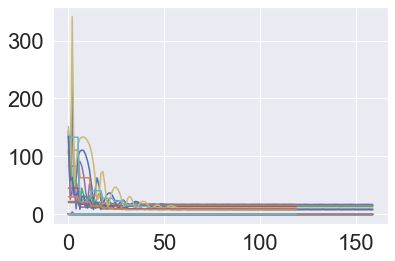

In [109]:

#trees = [5,10,15,20,25,40,50, 100, 200]
trees = [2,5,8,10,15,20,25]
for tree in trees:
    ## Default model
    model = RandomForestRegressor(max_features='auto', criterion='mse', max_depth=tree,max_leaf_nodes=None, 
                              min_samples_split=4, min_samples_leaf=4, n_estimators=150,n_jobs=-1)
    
    print("Fitting RF with trees ", tree)
    %time model.fit(train_X, train_y)
    rf = RFmodel(300, 'mae', train_X, train_y, valid_X, valid_y, model=model)
    rf.m
    t, v = rf.getRfLoss()
    print("RF train:",t," RF valid:", v)
    
    dicto = {
    "Trees": tree,
    "RFtrainLoss": t,
    "RFvalidLoss": v
    }
    
    rfdnn_chart = rfdnn_chart.append(dicto, ignore_index = True)
    
    
    train_ds, valid_ds = rf.fit_model(True)
    
    print("Running DNN for trees: ", tree, "Learning rate: 1e-03")
    
    rfDNN = RfDNN(train_ds, valid_ds, mse,trees = 150, bs=5000)
    rfDNN.runDNN(20)
    _, val_acc = rfDNN.getValidError(25000)
    valid_acc.append(val_acc)
    
    loss = rfDNN.recorder.plot_loss()
    valid_loss = rfDNN.recorder.plot_validloss()
    
    DNN_loss.append(loss)
    DNN_valid.append(valid_loss)
    DNN_mse.append(rfDNN.recorder.plot_mse())
    
    

In [110]:
valid_acc[-7:]

[17.082161049504727,
 15.44662504177615,
 14.598304989672155,
 14.362344275851697,
 13.630649887307138,
 13.446601281137914,
 13.354995713475198]

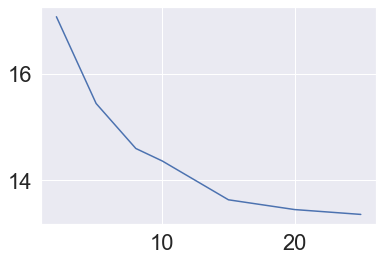

In [111]:
#valid_acc = [14.327687856320292, 13.908050280700625, 13.835922433082015, 13.80290648671873, 13.644046763748676,  13.609881568225473, 13.572946754029394, 13.457833254355938,  13.600723974976688]
plt.plot(trees, valid_acc[-7:])
plt.show()

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


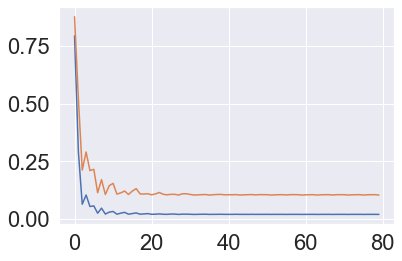

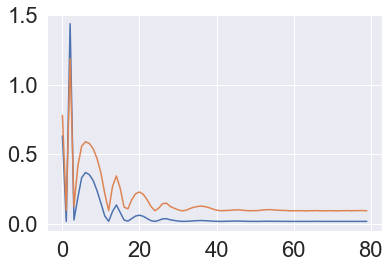

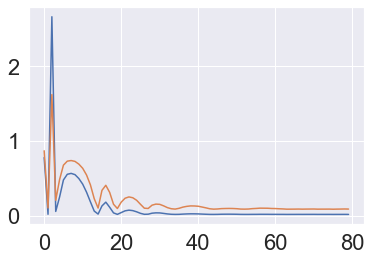

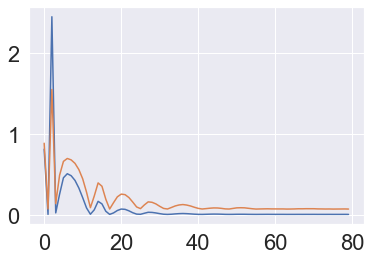

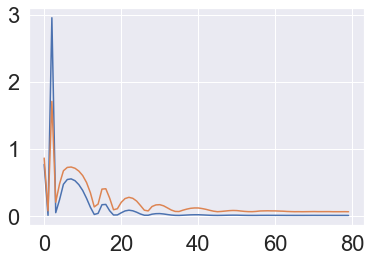

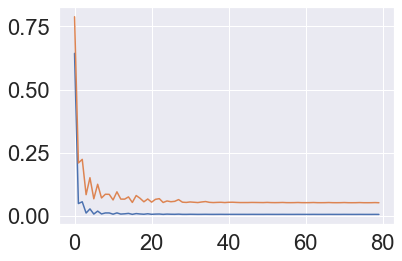

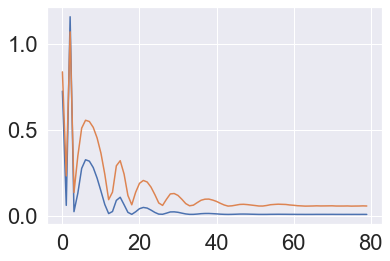

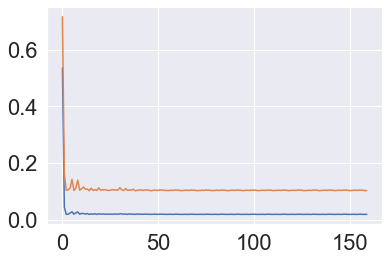

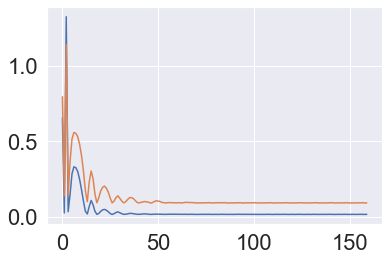

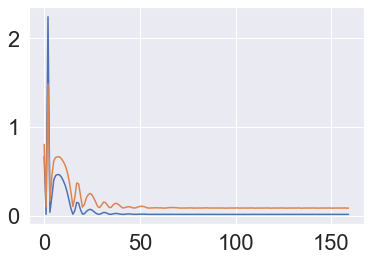

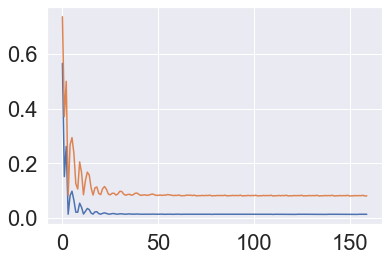

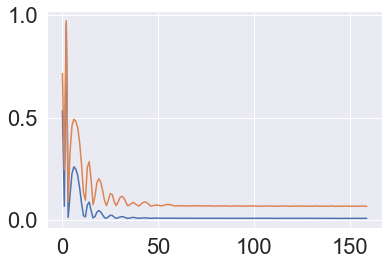

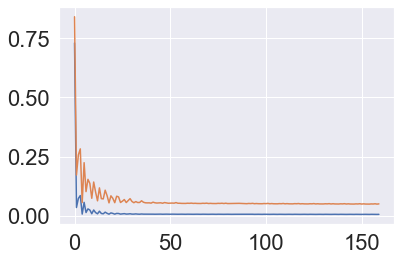

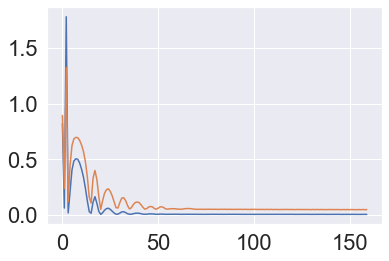

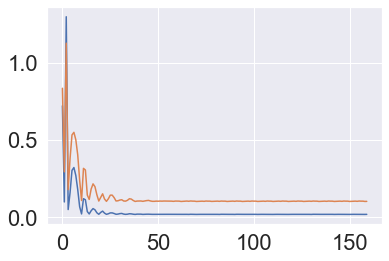

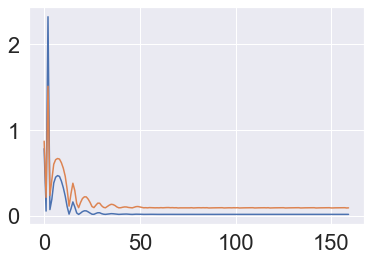

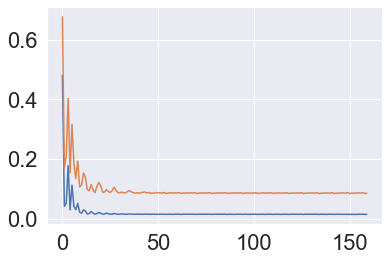

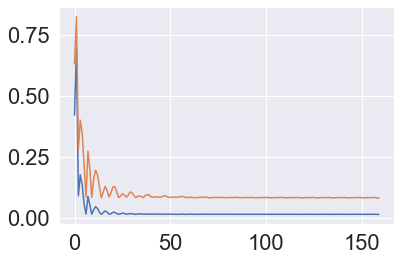

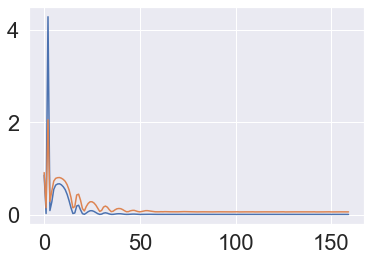

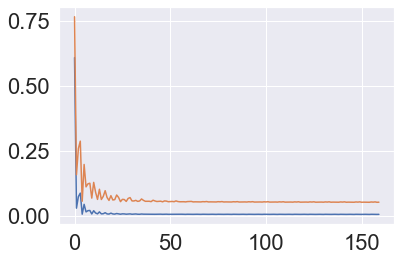

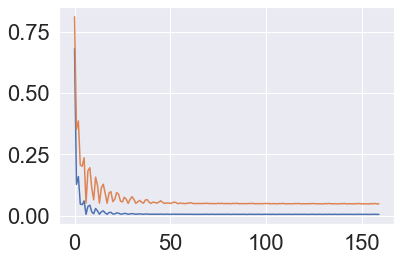

In [112]:
for i in range(len(DNN_loss)):
    plt.figure(i)
    plt.plot(DNN_loss[i][-180:])

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


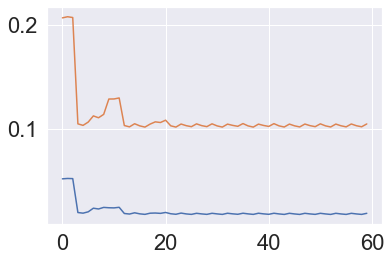

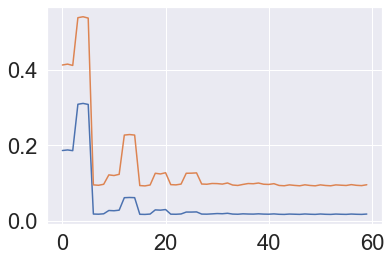

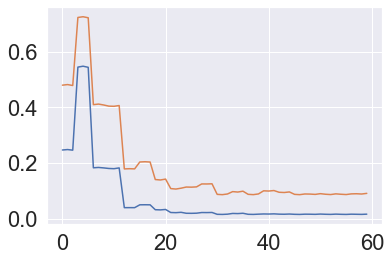

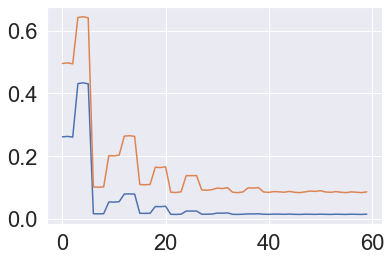

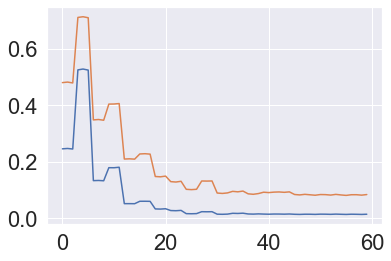

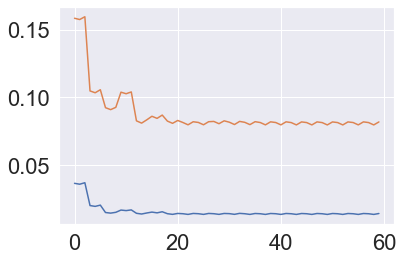

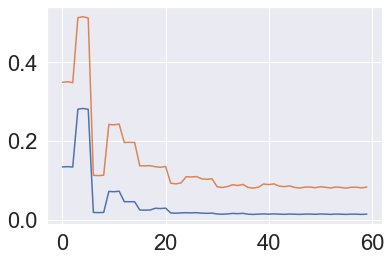

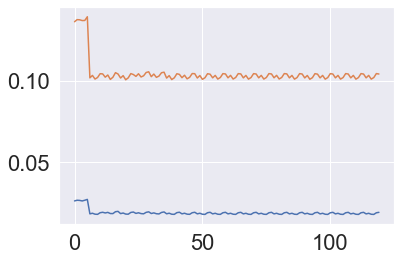

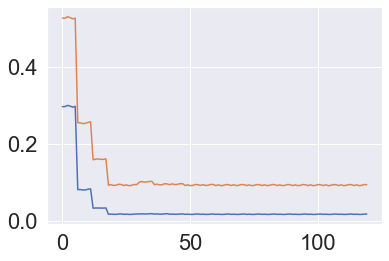

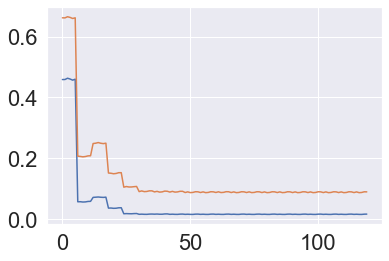

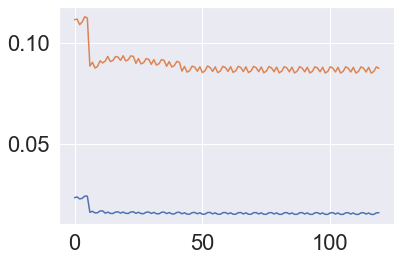

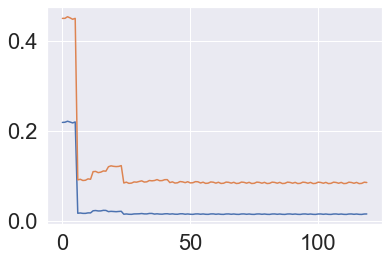

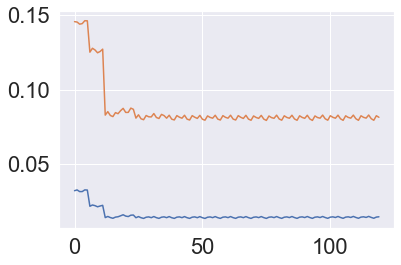

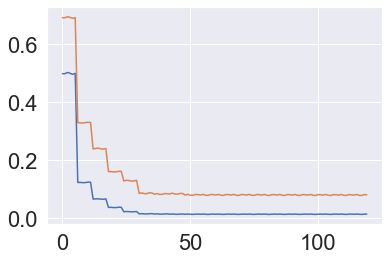

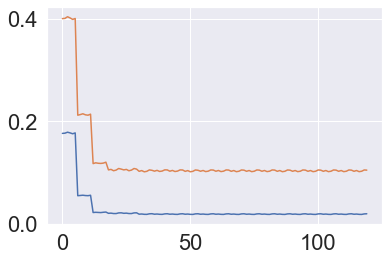

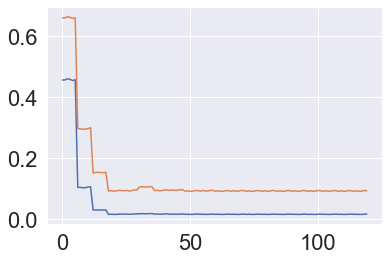

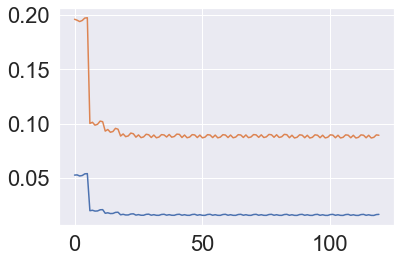

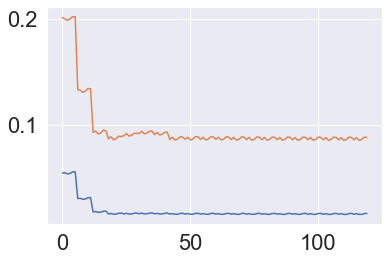

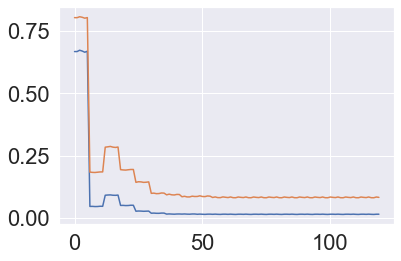

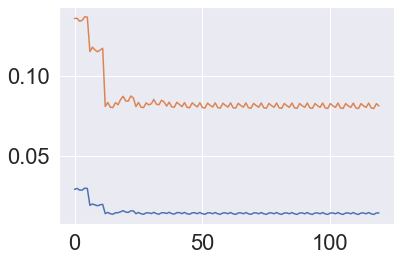

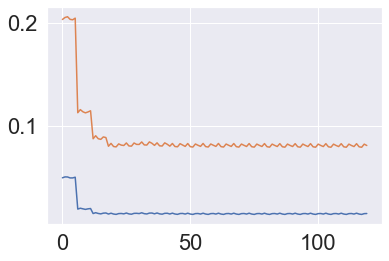

In [113]:
for i in range(len(DNN_valid)):
    plt.figure(i)
    plt.plot(DNN_valid[i])

In [114]:
rfdnn_chart[:7]

,Trees,RFtrainLoss,RFvalidLoss
0,2.0,17.352230,17.211203
1,5.0,15.476981,15.432265
2,8.0,14.063515,14.489662
3,10.0,13.047962,14.135084
4,15.0,10.312617,13.639502
5,20.0,8.660655,13.444282
6,25.0,8.127870,13.390089


In [115]:
valid_acc[-9:]

[13.480574106119127,
 13.36205010338828,
 17.082161049504727,
 15.44662504177615,
 14.598304989672155,
 14.362344275851697,
 13.630649887307138,
 13.446601281137914,
 13.354995713475198]

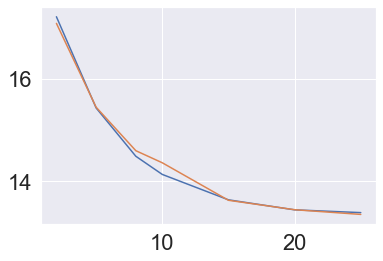

In [116]:
plt.plot(trees, rfdnn_chart[:7]['RFvalidLoss'])
plt.plot(trees[:7], valid_acc[-7:])
plt.show()

In [ ]:
# class Dataset(object):
#     """An abstract class representing a Dataset.

#     All other datasets should subclass it. All subclasses should override
#     ``__len__``, that provides the size of the dataset, and ``__getitem__``,
#     supporting integer indexing in range from 0 to len(self) exclusive.
#     """
#     def __init__(self, x,y):
#         self.x, self.y = x , y
        
#     def __getitem__(self, i):
#         return self.x[i], self.y[i]
    
#     def __len__(self):
#         return self.x.shape[1]
#     def total_size(self):
#         return self.x.shape[0]